In [ ]:
print(" Installing NLP and Deep Learning libraries...")
print("This may take 3-5 minutes...\n")

!pip install -q transformers
!pip install -q torch
!pip install -q nltk
!pip install -q textblob
!pip install -q wordcloud
!pip install -q tensorflow

print(" All libraries installed successfully!\n")

 Installing NLP and Deep Learning libraries...
This may take 3-5 minutes...

 All libraries installed successfully!



In [ ]:
import pandas as pd
import numpy as np
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Download NLTK data
print(" Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print(" NLTK data downloaded")

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout,
                                     Bidirectional, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Transformers
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, pipeline)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(" All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


 NLTK data downloaded
 All libraries imported successfully!
TensorFlow version: 2.19.0


In [ ]:
print("="*60)
print("LOADING DATA")
print("="*60)

print("\n Loading datasets...")

# Load reviews data
df_reviews = pd.read_csv('reviews.csv')
df_products = pd.read_csv('products.csv')
df_transactions = pd.read_csv('transactions.csv')

print(" Data loaded successfully!")
print(f"\n Data shapes:")
print(f"   Reviews: {df_reviews.shape}")
print(f"   Products: {df_products.shape}")
print(f"   Transactions: {df_transactions.shape}")

# Display sample reviews
print("\n Sample reviews:")
print(df_reviews[['review_text', 'rating']].head(10))


LOADING DATA

 Loading datasets...
 Data loaded successfully!

 Data shapes:
   Reviews: (20000, 8)
   Products: (1000, 9)
   Transactions: (50000, 10)

 Sample reviews:
                                 review_text  rating
0         Very satisfied with this purchase.       4
1         Best purchase I've made this year!       5
2           Disappointed with this purchase.       2
3         Best purchase I've made this year!       5
4    Outstanding product, worth every penny.       4
5      Great quality, exactly what I needed.       4
6          Average quality, nothing special.       3
7  It's fine, does what it's supposed to do.       3
8         Best purchase I've made this year!       4
9  It's fine, does what it's supposed to do.       3


In [ ]:
print("\n" + "="*60)
print("TEXT PREPROCESSING")
print("="*60)

print("\n🔧 Setting up text preprocessing pipeline...")

class TextPreprocessor:
    """Comprehensive text preprocessing for sentiment analysis"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def remove_stopwords(self, text):
        """Remove stopwords"""
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)

    def lemmatize_text(self, text):
        """Lemmatize words"""
        words = text.split()
        lemmatized = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized)

    def preprocess(self, text, remove_stopwords=True, lemmatize=True):
        """Full preprocessing pipeline"""
        text = self.clean_text(text)

        if remove_stopwords:
            text = self.remove_stopwords(text)

        if lemmatize:
            text = self.lemmatize_text(text)

        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()

print(" Preprocessor initialized!")

# Apply preprocessing
print("\n Preprocessing review texts...")
df_reviews['cleaned_text'] = df_reviews['review_text'].apply(
    lambda x: preprocessor.preprocess(x)
)

print(" Text preprocessing completed!")
print("\n Sample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {df_reviews['review_text'].iloc[i]}")
    print(f"Cleaned:  {df_reviews['cleaned_text'].iloc[i]}")

# Remove empty reviews
df_reviews = df_reviews[df_reviews['cleaned_text'].str.len() > 0].reset_index(drop=True)
print(f"\n Final dataset size: {len(df_reviews):,} reviews")



TEXT PREPROCESSING

🔧 Setting up text preprocessing pipeline...
 Preprocessor initialized!

 Preprocessing review texts...
 Text preprocessing completed!

 Sample preprocessed texts:

Original: Very satisfied with this purchase.
Cleaned:  satisfied purchase

Original: Best purchase I've made this year!
Cleaned:  best purchase ive made year

Original: Disappointed with this purchase.
Cleaned:  disappointed purchase

 Final dataset size: 20,000 reviews



CREATING SENTIMENT LABELS

  Creating sentiment labels from ratings...
 Sentiment labels created!

 Sentiment distribution:
   Negative: 2,080 (10.4%)
   Neutral: 2,965 (14.8%)
   Positive: 14,955 (74.8%)


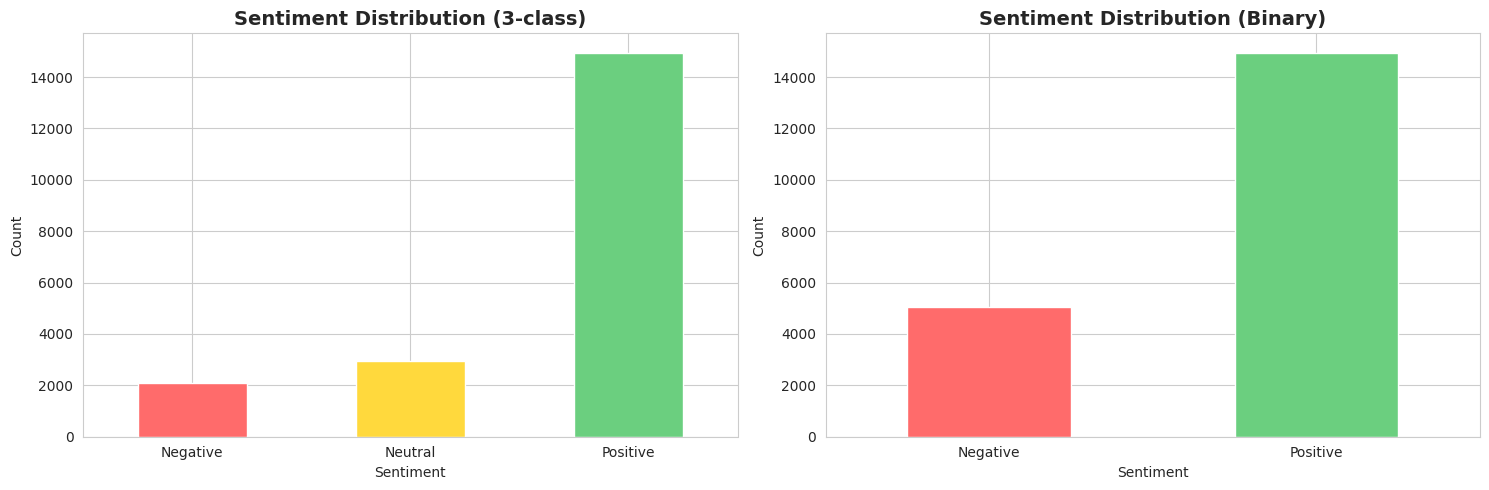

In [ ]:
print("\n" + "="*60)
print("CREATING SENTIMENT LABELS")
print("="*60)

print("\n  Creating sentiment labels from ratings...")

# Create sentiment labels
# 1-2 stars: Negative (0)
# 3 stars: Neutral (1)
# 4-5 stars: Positive (2)

def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df_reviews['sentiment'] = df_reviews['rating'].apply(rating_to_sentiment)

# Binary classification version (for some models)
# 1-3 stars: Negative (0)
# 4-5 stars: Positive (1)
df_reviews['sentiment_binary'] = (df_reviews['rating'] >= 4).astype(int)

print(" Sentiment labels created!")
print("\n Sentiment distribution:")
sentiment_counts = df_reviews['sentiment'].value_counts().sort_index()
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for sent, count in sentiment_counts.items():
    pct = count / len(df_reviews) * 100
    print(f"   {sentiment_labels[sent]}: {count:,} ({pct:.1f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 3-class sentiment
sentiment_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#FFD93D', '#6BCF7F'])
axes[0].set_title('Sentiment Distribution (3-class)', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

# Binary sentiment
binary_counts = df_reviews['sentiment_binary'].value_counts().sort_index()
binary_counts.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#6BCF7F'])
axes[1].set_title('Sentiment Distribution (Binary)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Negative', 'Positive'], rotation=0)

plt.tight_layout()
plt.show()


TEXT VISUALIZATION - WORD CLOUDS

 Generating word clouds for each sentiment...


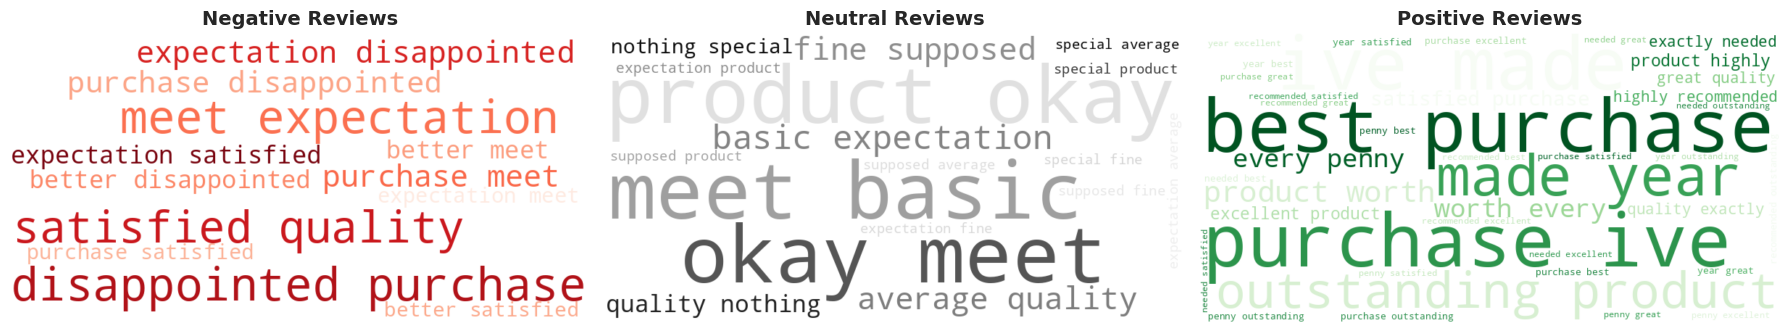

 Word clouds generated!


In [ ]:
print("\n" + "="*60)
print("TEXT VISUALIZATION - WORD CLOUDS")
print("="*60)

print("\n Generating word clouds for each sentiment...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sentiments = [0, 1, 2]
colors = ['Reds', 'Greys', 'Greens']
titles = ['Negative Reviews', 'Neutral Reviews', 'Positive Reviews']

for idx, (sentiment, color, title) in enumerate(zip(sentiments, colors, titles)):
    # Get text for this sentiment
    text = ' '.join(df_reviews[df_reviews['sentiment'] == sentiment]['cleaned_text'])

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=50
    ).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(title, fontweight='bold', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(" Word clouds generated!")



TRADITIONAL ML SENTIMENT ANALYSIS

 Training traditional ML models...

 Data split:
   Training samples: 16,000
   Test samples: 4,000

 Creating TF-IDF features...
 TF-IDF features created: (16000, 58)

 Training multiple ML models...

   Training Logistic Regression...
    Logistic Regression - Accuracy: 1.0000, F1: 1.0000

   Training Naive Bayes...
    Naive Bayes - Accuracy: 1.0000, F1: 1.0000

   Training Linear SVM...
    Linear SVM - Accuracy: 1.0000, F1: 1.0000

   Training Random Forest...
    Random Forest - Accuracy: 1.0000, F1: 1.0000

 Traditional ML Models - Results Summary:
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression       1.0        1.0     1.0       1.0
        Naive Bayes       1.0        1.0     1.0       1.0
         Linear SVM       1.0        1.0     1.0       1.0
      Random Forest       1.0        1.0     1.0       1.0


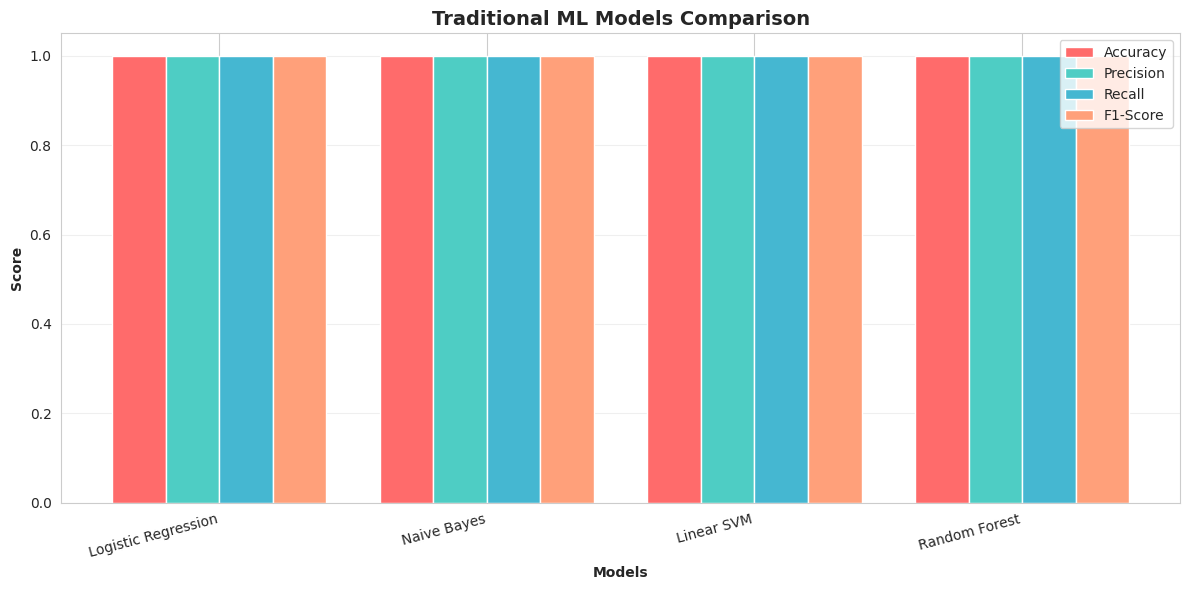


 Best traditional ML model: Logistic Regression
   F1-Score: 1.0000


In [ ]:
print("\n" + "="*60)
print("TRADITIONAL ML SENTIMENT ANALYSIS")
print("="*60)

print("\n Training traditional ML models...")

# Prepare data for binary classification (easier to start with)
X = df_reviews['cleaned_text']
y = df_reviews['sentiment_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Data split:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

# Create TF-IDF features
print("\n Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f" TF-IDF features created: {X_train_tfidf.shape}")

# Train multiple models
print("\n Training multiple ML models...")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\n   Training {name}...")

    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    print(f"    {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Results DataFrame
df_ml_results = pd.DataFrame(results)

print("\n Traditional ML Models - Results Summary:")
print(df_ml_results.to_string(index=False))

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df_ml_results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, df_ml_results[metric], width, label=metric, color=color)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Traditional ML Models Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(df_ml_results['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Save best model
best_model_name = df_ml_results.loc[df_ml_results['F1-Score'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\n Best traditional ML model: {best_model_name}")
print(f"   F1-Score: {df_ml_results['F1-Score'].max():.4f}")




DEEP LEARNING - LSTM SENTIMENT ANALYSIS

🔧 Building LSTM model...
   Tokenizing text...
 Sequences prepared: (16000, 100)

  Building LSTM architecture...
 LSTM model built!

 Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Training LSTM model...
   This may take 5-10 minutes...

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8598 - loss: 0.3181 - val_accuracy: 1.0000 - val_loss: 6.3560e-06 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 1.0000 - loss: 2.5503e-04 - val_accuracy: 1.0000 - val_loss: 1.0058e-06 - learning_rate: 0.0010
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 1.0000 - loss: 1.1405e-04 - val_accuracy: 1.0000 - val_loss: 3.7327e-07 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 1.0000 - loss: 5.9672e-05 - val_accuracy: 1.0000 - val_loss: 2.5001e-07 - learning_rate: 5.0000e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 1.0000 - loss: 5.2461e-05 - val_accuracy: 1.0000 - val_loss: 1.6046e-07 - learning_rate: 5.0000e-04
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 1.0000 - loss: 4.4843e-05 - val_accuracy: 1.0000 - val_loss: 1

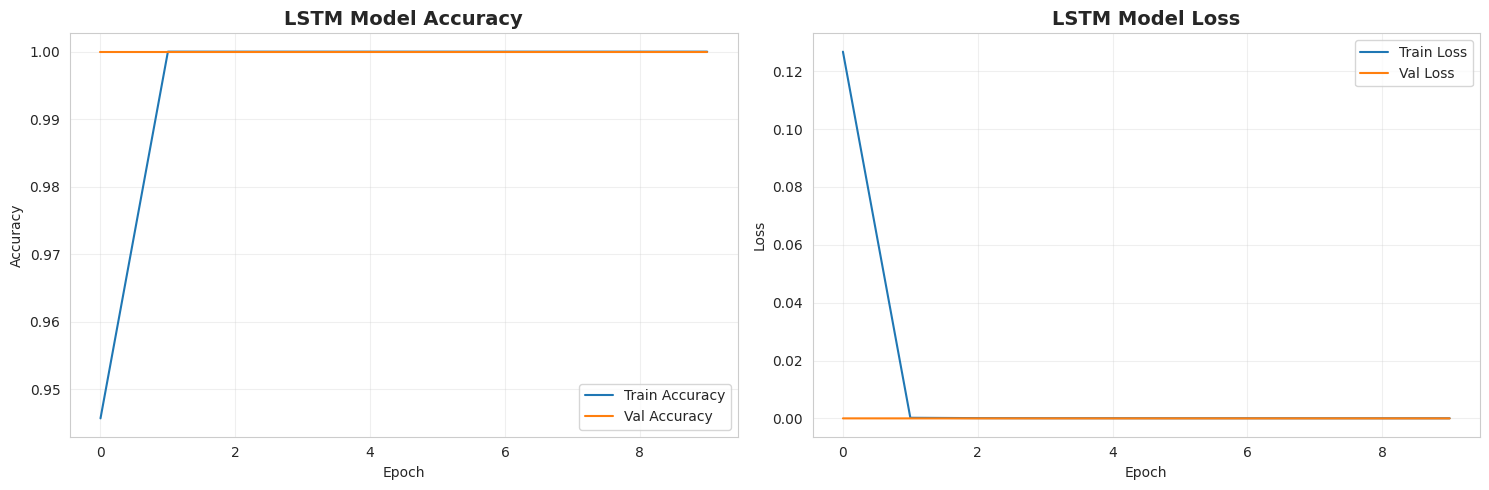

In [ ]:
print("\n" + "="*60)
print("DEEP LEARNING - LSTM SENTIMENT ANALYSIS")
print("="*60)

print("\n🔧 Building LSTM model...")

# Prepare data for LSTM
max_words = 10000
max_len = 100

# Tokenize text
print("   Tokenizing text...")
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f" Sequences prepared: {X_train_pad.shape}")

# Build LSTM model
print("\n  Building LSTM architecture...")

model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(" LSTM model built!")
print("\n Model architecture:")
model_lstm.summary()

# Train LSTM
print("\n Training LSTM model...")
print("   This may take 5-10 minutes...\n")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

history = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n LSTM training completed!")

# Evaluate LSTM
print("\n Evaluating LSTM model...")
y_pred_lstm_proba = model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm)
lstm_recall = recall_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)

print(f"\nLSTM Results:")
print(f"   Accuracy:  {lstm_accuracy:.4f}")
print(f"   Precision: {lstm_precision:.4f}")
print(f"   Recall:    {lstm_recall:.4f}")
print(f"   F1-Score:  {lstm_f1:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('LSTM Model Accuracy', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('LSTM Model Loss', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
print("\n" + "="*60)
print("BERT-BASED SENTIMENT ANALYSIS")
print("="*60)

print("\n Using pre-trained BERT model for sentiment analysis...")
print("   Note: We'll use a pre-trained sentiment model (faster)")

# Use pre-trained sentiment analysis pipeline
print("\n Loading pre-trained BERT sentiment model...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # Use CPU (change to 0 for GPU)
)

print(" BERT model loaded!")

# Test on sample reviews
print("\n Testing BERT on sample reviews...")

sample_reviews = X_test.head(5).tolist()
bert_predictions = sentiment_pipeline(sample_reviews)

print("\nSample predictions:")
for review, pred, actual in zip(sample_reviews[:5], bert_predictions[:5], y_test.head(5)):
    print(f"\nReview: {review[:100]}...")
    print(f"BERT Prediction: {pred['label']} (confidence: {pred['score']:.4f})")
    print(f"Actual: {'Positive' if actual == 1 else 'Negative'}")

# Evaluate BERT on full test set (sample for speed)
print("\n Evaluating BERT on test set...")
print("   Using sample of 500 reviews for speed...")

test_sample = X_test.head(500).tolist()
y_test_sample = y_test.head(500)

# Get predictions
bert_results = sentiment_pipeline(test_sample, batch_size=16)

# Convert to binary (POSITIVE=1, NEGATIVE=0)
y_pred_bert = [1 if r['label'] == 'POSITIVE' else 0 for r in bert_results]

# Calculate metrics
bert_accuracy = accuracy_score(y_test_sample, y_pred_bert)
bert_precision = precision_score(y_test_sample, y_pred_bert)
bert_recall = recall_score(y_test_sample, y_pred_bert)
bert_f1 = f1_score(y_test_sample, y_pred_bert)

print(f"\nBERT Results (on 500 samples):")
print(f"   Accuracy:  {bert_accuracy:.4f}")
print(f"   Precision: {bert_precision:.4f}")
print(f"   Recall:    {bert_recall:.4f}")
print(f"   F1-Score:  {bert_f1:.4f}")



BERT-BASED SENTIMENT ANALYSIS

 Using pre-trained BERT model for sentiment analysis...
   Note: We'll use a pre-trained sentiment model (faster)

 Loading pre-trained BERT sentiment model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


 BERT model loaded!

 Testing BERT on sample reviews...

Sample predictions:

Review: best purchase ive made year...
BERT Prediction: POSITIVE (confidence: 0.9994)
Actual: Positive

Review: best purchase ive made year...
BERT Prediction: POSITIVE (confidence: 0.9994)
Actual: Positive

Review: outstanding product worth every penny...
BERT Prediction: POSITIVE (confidence: 0.9999)
Actual: Positive

Review: excellent product highly recommended...
BERT Prediction: POSITIVE (confidence: 0.9998)
Actual: Positive

Review: best purchase ive made year...
BERT Prediction: POSITIVE (confidence: 0.9994)
Actual: Positive

 Evaluating BERT on test set...
   Using sample of 500 reviews for speed...

BERT Results (on 500 samples):
   Accuracy:  0.8240
   Precision: 0.8070
   Recall:    1.0000
   F1-Score:  0.8932



COMPLETE MODEL COMPARISON

 COMPLETE MODEL COMPARISON:
               Model  Accuracy  Precision  Recall  F1-Score
 Logistic Regression     1.000   1.000000     1.0  1.000000
         Naive Bayes     1.000   1.000000     1.0  1.000000
          Linear SVM     1.000   1.000000     1.0  1.000000
       Random Forest     1.000   1.000000     1.0  1.000000
LSTM (Deep Learning)     1.000   1.000000     1.0  1.000000
  BERT (Transformer)     0.824   0.807018     1.0  0.893204


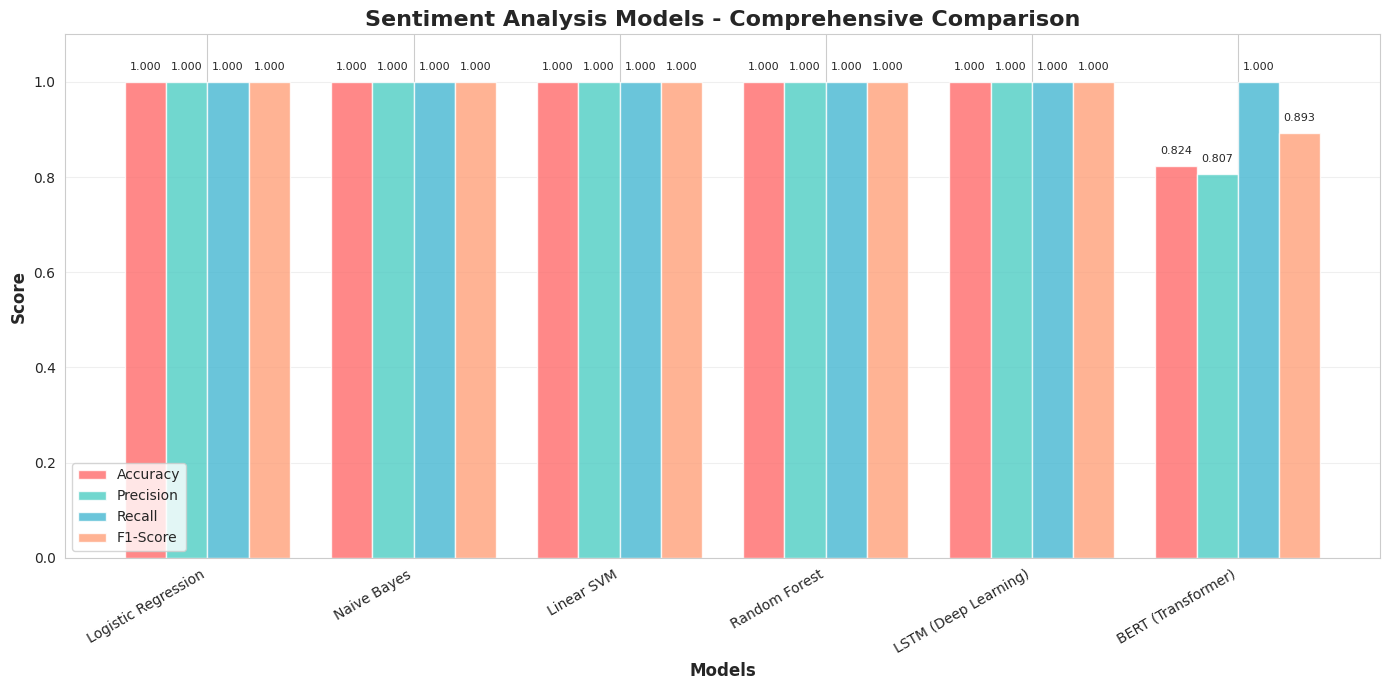


 BEST MODEL OVERALL: Logistic Regression
   F1-Score: 1.0000


In [ ]:
print("\n" + "="*60)
print("COMPLETE MODEL COMPARISON")
print("="*60)

# Compile all results
all_results = df_ml_results.copy()

# Add LSTM results
all_results = pd.concat([all_results, pd.DataFrame([{
    'Model': 'LSTM (Deep Learning)',
    'Accuracy': lstm_accuracy,
    'Precision': lstm_precision,
    'Recall': lstm_recall,
    'F1-Score': lstm_f1
}])], ignore_index=True)

# Add BERT results
all_results = pd.concat([all_results, pd.DataFrame([{
    'Model': 'BERT (Transformer)',
    'Accuracy': bert_accuracy,
    'Precision': bert_precision,
    'Recall': bert_recall,
    'F1-Score': bert_f1
}])], ignore_index=True)

print("\n COMPLETE MODEL COMPARISON:")
print(all_results.to_string(index=False))

# Visualize comprehensive comparison
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(all_results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, all_results[metric], width, label=metric, color=color, alpha=0.8)

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Sentiment Analysis Models - Comprehensive Comparison',
             fontweight='bold', fontsize=16)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(all_results['Model'], rotation=30, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels on bars
for i in range(len(all_results)):
    for j, metric in enumerate(metrics):
        value = all_results[metric].iloc[i]
        ax.text(i + j*width, value + 0.02, f'{value:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Best model
best_model_overall = all_results.loc[all_results['F1-Score'].idxmax(), 'Model']
best_f1_overall = all_results['F1-Score'].max()

print(f"\n BEST MODEL OVERALL: {best_model_overall}")
print(f"   F1-Score: {best_f1_overall:.4f}")


In [ ]:
print("\n" + "="*60)
print("PRODUCTION-READY SENTIMENT PREDICTION")
print("="*60)

def predict_sentiment(text, method='best'):
    """
    Predict sentiment for a given text

    Args:
        text: Input review text
        method: 'traditional', 'lstm', 'bert', or 'best'

    Returns:
        dict with sentiment label and confidence
    """

    # Preprocess text
    cleaned = preprocessor.preprocess(text)

    if method == 'traditional' or method == 'best':
        # Use best traditional ML model
        text_tfidf = tfidf.transform([cleaned])
        pred_proba = best_model.predict_proba(text_tfidf)[0]
        pred_label = best_model.predict(text_tfidf)[0]
        confidence = max(pred_proba)

        return {
            'sentiment': 'Positive' if pred_label == 1 else 'Negative',
            'confidence': float(confidence),
            'method': 'Logistic Regression'
        }

    elif method == 'lstm':
        # Use LSTM model
        seq = tokenizer.texts_to_sequences([cleaned])
        pad = pad_sequences(seq, maxlen=max_len, padding='post')
        pred_proba = model_lstm.predict(pad, verbose=0)[0][0]
        pred_label = 1 if pred_proba > 0.5 else 0

        return {
            'sentiment': 'Positive' if pred_label == 1 else 'Negative',
            'confidence': float(pred_proba) if pred_label == 1 else float(1 - pred_proba),
            'method': 'LSTM'
        }

    elif method == 'bert':
        # Use BERT model
        result = sentiment_pipeline(text)[0]

        return {
            'sentiment': result['label'].capitalize(),
            'confidence': float(result['score']),
            'method': 'BERT'
        }

print(" Sentiment prediction function ready!")

# Test the function
print("\n Testing sentiment prediction...")

test_reviews_demo = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality, complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job.",
]

for review in test_reviews_demo:
    print(f"\n{'='*60}")
    print(f"Review: {review}")
    print(f"{'='*60}")

    for method in ['traditional', 'lstm', 'bert']:
        result = predict_sentiment(review, method=method)
        print(f"{result['method']:20s} → {result['sentiment']:8s} (confidence: {result['confidence']:.3f})")



PRODUCTION-READY SENTIMENT PREDICTION
 Sentiment prediction function ready!

 Testing sentiment prediction...

Review: This product is absolutely amazing! Best purchase ever!
Logistic Regression  → Positive (confidence: 0.987)
LSTM                 → Positive (confidence: 1.000)
BERT                 → Positive (confidence: 1.000)

Review: Terrible quality, complete waste of money. Very disappointed.
Logistic Regression  → Negative (confidence: 0.973)
LSTM                 → Negative (confidence: 1.000)
BERT                 → Negative (confidence: 1.000)

Review: It's okay, nothing special but does the job.
Logistic Regression  → Negative (confidence: 0.979)
LSTM                 → Negative (confidence: 1.000)
BERT                 → Positive (confidence: 1.000)


In [ ]:
print("\n" + "="*60)
print("SAVING MODELS AND ARTIFACTS")
print("="*60)

print("\n Saving all models and results...")

# Save traditional ML model
with open('sentiment_ml_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(" Traditional ML model saved")

# Save TF-IDF vectorizer
with open('sentiment_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print(" TF-IDF vectorizer saved")

# Save LSTM model
model_lstm.save('sentiment_lstm_model.h5')
print(" LSTM model saved")

# Save tokenizer
with open('sentiment_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print(" Tokenizer saved")

# Save preprocessor
with open('text_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print(" Text preprocessor saved")

# Save results
all_results.to_csv('sentiment_models_comparison.csv', index=False)
print(" Model comparison saved")

# Save processed reviews with sentiments
df_reviews.to_csv('reviews_with_sentiment.csv', index=False)
print(" Processed reviews saved")





SAVING MODELS AND ARTIFACTS

 Saving all models and results...
 Traditional ML model saved
 TF-IDF vectorizer saved
 LSTM model saved
 Tokenizer saved
 Text preprocessor saved
 Model comparison saved
 Processed reviews saved


In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create folder in Drive
import os
os.makedirs('/content/drive/MyDrive/ML_Internship_Models', exist_ok=True)

# Copy ONLY essential files to Drive
import shutil

essential_files = [
    'sentiment_ml_model.pkl',
    'sentiment_tfidf.pkl',
    'sentiment_tokenizer.pkl',
    'text_preprocessor.pkl',
    'sentiment_models_comparison.csv',
    'reviews_with_sentiment.csv'
]

for file in essential_files:
    if os.path.exists(file):
        shutil.copy(file, f'/content/drive/MyDrive/ML_Internship_Models/{file}')
        print(f"✅ Copied {file}")

print("\n✅ Essential files saved to Google Drive!")

Mounted at /content/drive
✅ Copied sentiment_ml_model.pkl
✅ Copied sentiment_tfidf.pkl
✅ Copied sentiment_tokenizer.pkl
✅ Copied text_preprocessor.pkl
✅ Copied sentiment_models_comparison.csv
✅ Copied reviews_with_sentiment.csv

✅ Essential files saved to Google Drive!
